## This is my first attempt to load OPM data into MNE. 

Seems to load fine. A few things to sort:

- Scaling is weird. Does MNE apply some unknown scaling  factor to mags?
- Montage (sensor positions) not applied to raw
- MNE seems to treat montages as EEG electrodes
- How do we input orientation of sensors?
- Epoching?
- SSP is weird





In [ ]:
def load_UCL_OPM(raw_name, chan_name, json_file, pos_file):
    # Import the necessary packages
    import numpy as np
    import matplotlib.pyplot as plt
    import mne
    import pandas as pd
    import json

    # Load 1D data from .bin file
    d = np.fromfile(raw_name,'>f4')
    
    print('Data loaded as: ' + str(d.dtype))
    
    # Load tsv channels file
    tsv = pd.read_csv(chan_name,sep='\t')
    
    # Replace the channel types with a
    tsv['type'] = tsv['type'].replace('MEGMAG','mag')
    tsv['type'] = tsv['type'].replace('TRIG','stim')
    tsv['type'] = tsv['type'].replace('REF','ref_meg')
    
    # Replace Flux channels with misc
    tsv.loc[tsv.name.str.contains('Flux'), 'type'] = 'misc'
    
    # Put these into a list
    chans = tsv['name'].values.tolist()
    types = tsv['type'].values.tolist()
    
    # Open the _meg.json and extract the sampling freq
    with open(chan_json) as json_file:
        json_meg = json.load(json_file)

    Fs = json_meg['SamplingFrequency']
    
    # Make a montage
    pos_tsv = pd.read_csv(pos_file,sep='\t')

    dict = {}

    for e in np.arange(0,len(pos_tsv)):
        dict[pos_tsv.name[e]] = np.array([pos_tsv.Px[e]/1000,pos_tsv.Py[e]/1000,pos_tsv.Pz[e]/1000])

    montage_opm = mne.channels.make_dig_montage(ch_pos=dict,coord_frame='mri')
    
    # Create MNE info field
    inf = mne.create_info(chans, Fs, ch_types = types, montage=montage_opm, verbose=None)
    
    # Reshape the 1D data into 2D based on the number of channels present
    d2 = np.reshape(d, [len(chans), int(len(d)/len(chans))],'F')
    
    # Create raw MNE object
    raw = mne.io.RawArray(d2, inf, first_samp=0, copy='auto', verbose=None)
    
    return raw
    

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
import json
import os.path as op

In [83]:
%matplotlib tk

In [7]:
# Path to data
script_dir      = '/Users/rseymoue/Documents/GitHub/analyse_OPMEG'
data_dir        = '/Volumes/Robert T5/OPM_data/benchmarking_26_02/'
save_dir        = '/Users/rseymoue/Documents/GitHub/opm_benchmarking_feb_2020/'

In [10]:
cd ../

/


In [11]:
cd ./Volumes/Robert\ T5/OPM_data/benchmarking_26_02/

/Volumes/Robert T5/OPM_data/benchmarking_26_02


In [76]:
raw_name     = op.join(data_dir, 'sub-002/', 'ses-001/','meg/','sub-002_ses-001_task-faces_run-001_meg.bin')
raw_emptyroom_name     = op.join(data_dir, 'sub-001/', 'ses-001/','meg/','sub-001_ses-001_task-noise_run-001_meg.bin')
chan_name    = op.join(data_dir, 'sub-002/', 'ses-001/','meg/','sub-002_ses-001_task-faces_run-001_channels.tsv')
chan_json    = op.join(data_dir, 'sub-002/', 'ses-001/','meg/','sub-002_ses-001_task-faces_run-001_meg.json')
pos_file     = op.join(data_dir, 'sub-002/', 'ses-001/','meg/','sub-002_ses-001_task-faces_run-001_positions.tsv')


In [125]:
raw       = load_UCL_OPM(raw_name, chan_name, chan_json, pos_file)
raw_noise = load_UCL_OPM(raw_emptyroom_name, chan_name, chan_json, pos_file)

Data loaded as: >f4


<ipython-input-52-660df6972b07>:46: DeprecationWarning: Passing montage to create_info is deprecated and will be removed in 0.21, use raw.set_montage (or epochs.set_montage, etc.) instead
  inf = mne.create_info(chans, Fs, ch_types = types, montage=montage_opm, verbose=None)
<ipython-input-52-660df6972b07>:46: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  inf = mne.create_info(chans, Fs, ch_types = types, montage=montage_opm, verbose=None)


Creating RawArray with float64 data, n_channels=39, n_times=5315880
Current compensation grade : 0
    Range : 0 ... 5315879 =      0.000 ...   885.980 secs
Ready.
Data loaded as: >f4


<ipython-input-52-660df6972b07>:46: DeprecationWarning: Passing montage to create_info is deprecated and will be removed in 0.21, use raw.set_montage (or epochs.set_montage, etc.) instead
  inf = mne.create_info(chans, Fs, ch_types = types, montage=montage_opm, verbose=None)
<ipython-input-52-660df6972b07>:46: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  inf = mne.create_info(chans, Fs, ch_types = types, montage=montage_opm, verbose=None)


Creating RawArray with float64 data, n_channels=39, n_times=1968480
Current compensation grade : 0
    Range : 0 ... 1968479 =      0.000 ...   328.080 secs
Ready.


In [126]:
raw.drop_channels(raw.info.ch_names[0:6])
raw.drop_channels('NI-TRIG')
raw_noise.drop_channels(raw_noise.info.ch_names[0:6])
raw_noise.drop_channels('NI-TRIG')

<RawArray | 32 x 1968480 (328.1 s), ~480.7 MB, data loaded>

In [127]:
raw.resample(1000)
raw_noise.resample(1000)

<RawArray | 32 x 328080 (328.1 s), ~80.2 MB, data loaded>

Setting up band-pass filter from 2 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 2.00, 100.00 Hz: -6.02, -6.02 dB



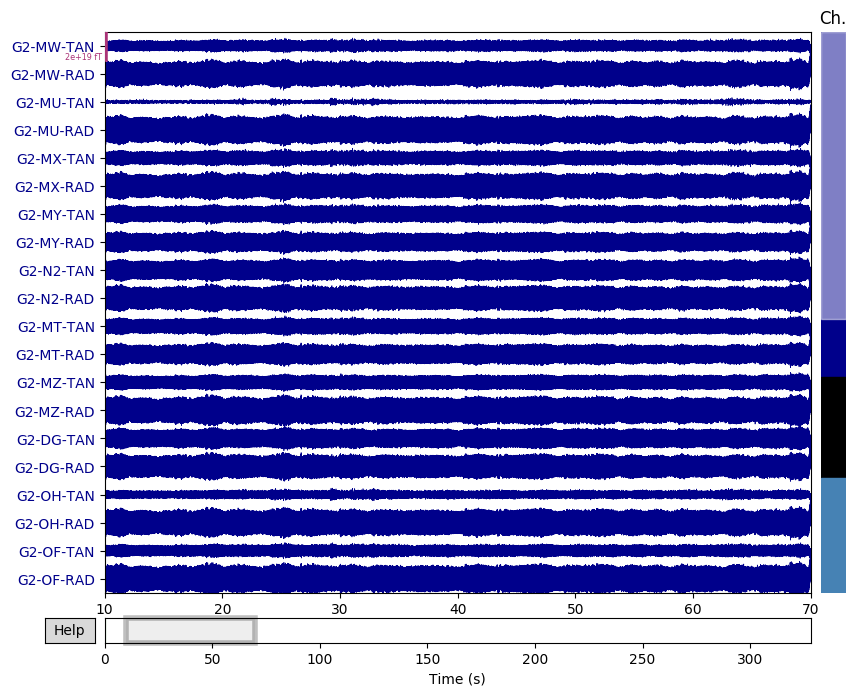

In [91]:
raw.plot(highpass=2, lowpass=100, remove_dc=True, scalings = 1e4, start=10.0,duration = 60)

In [68]:
raw = raw.notch_filter(np.arange(50, 251, 50),notch_widths=2)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)



In [70]:
raw = raw.notch_filter(120,notch_widths=2)

Setting up band-stop filter from 1.2e+02 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 118.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 118.25 Hz)
- Upper passband edge: 121.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 121.75 Hz)
- Filter length: 6601 samples (6.601 sec)



Effective window size : 2.048 (s)


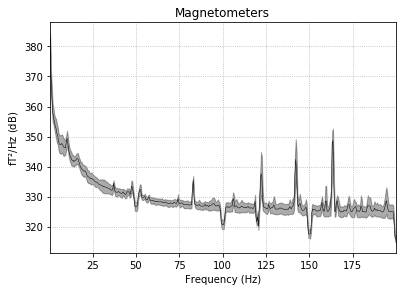

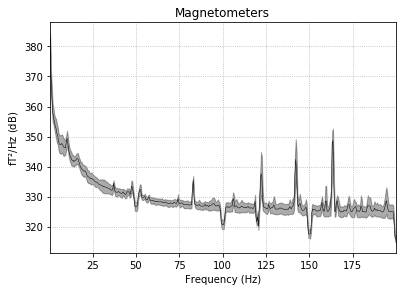

In [71]:
raw.plot_psd(average=True,fmin=0.1,fmax=200)

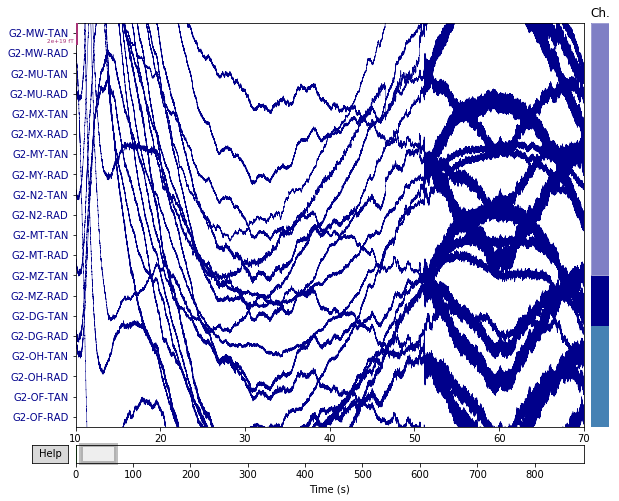

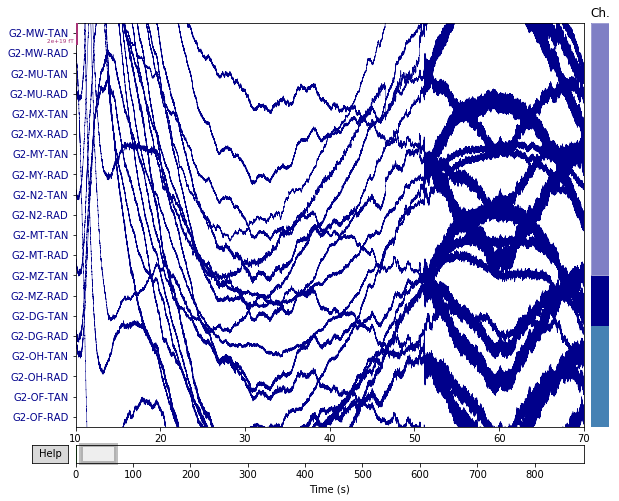

In [72]:
raw.plot(scalings = 1e4, start=10.0,duration = 60)

In [128]:
ssp1 = mne.compute_proj_raw(raw_noise,n_mag=15)

328 matching events found
No baseline correction applied
Not setting metadata
No gradiometers found. Forcing n_grad to 0
Adding projection: axial-Raw-0.000-328.080-PCA-01
Adding projection: axial-Raw-0.000-328.080-PCA-02
Adding projection: axial-Raw-0.000-328.080-PCA-03
Adding projection: axial-Raw-0.000-328.080-PCA-04
Adding projection: axial-Raw-0.000-328.080-PCA-05
Adding projection: axial-Raw-0.000-328.080-PCA-06
Adding projection: axial-Raw-0.000-328.080-PCA-07
Adding projection: axial-Raw-0.000-328.080-PCA-08
Adding projection: axial-Raw-0.000-328.080-PCA-09
Adding projection: axial-Raw-0.000-328.080-PCA-10
Adding projection: axial-Raw-0.000-328.080-PCA-11
Adding projection: axial-Raw-0.000-328.080-PCA-12
Adding projection: axial-Raw-0.000-328.080-PCA-13
Adding projection: axial-Raw-0.000-328.080-PCA-14
Adding projection: axial-Raw-0.000-328.080-PCA-15


In [129]:
raw.add_proj(ssp1)

15 projection items deactivated


<RawArray | 32 x 885980 (886.0 s), ~216.4 MB, data loaded>

In [130]:
raw.apply_proj()

Created an SSP operator (subspace dimension = 15)
15 projection items activated
SSP projectors applied...


<RawArray | 32 x 885980 (886.0 s), ~216.4 MB, data loaded>

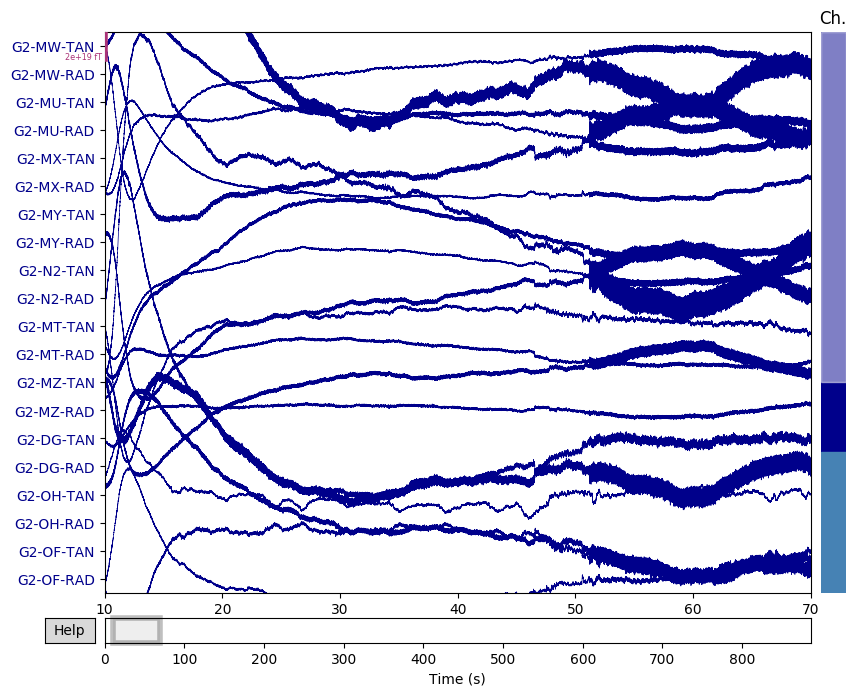

In [131]:
raw.plot(start=10.0,duration = 60, scalings = 1e4)

In [ ]:
raw.plot_projs_topomap(ssp1)

Effective window size : 2.048 (s)


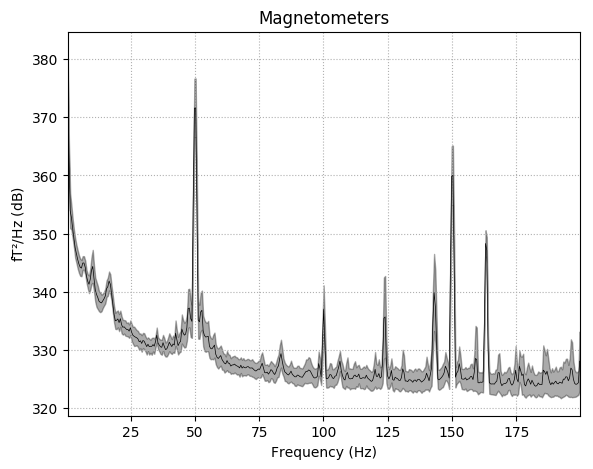

In [133]:
raw_noise.plot_psd(average=True,fmin=0.1,fmax=200)